## Examples of the Ranking-Aware CLIP

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import torch
import torchvision as tv
import open_clip
from pycocotools.coco import COCO
from open_clip.clip_model_adapter import L2RCLIP

/root/.cache/pypoetry/virtualenvs/rankingclip-cH07tm8f-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/.cache/pypoetry/virtualenvs/rankingclip-cH07tm8f-py3.9/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def render_figures_with_order(
    image_list,
    values,
    sup_values=None,
    figure_title=None,
    show_value=True,
):
    if sup_values is None:
        compact = list(zip(image_list, values))
    else:
        compact = list(zip(image_list, values, sup_values))
    sorted_data = sorted(compact, key=lambda x: x[1], reverse=True)
    plt.figure(figsize=(16, 12))
    for i, (image, value, *sup_value) in enumerate(sorted_data):
        plt.subplot(1, len(image_list), i + 1)
        plt.imshow(image)
        plt.axis('off')
        if show_value:
            if sup_values is None:
                v = f'score={value:.4f}'
            else:
                v = f'true/pred score = {sup_value[0]:.4f}/{value:.4f}'
            plt.title(v)
    plt.tight_layout()
    plt.show()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
config_path = './configs/model-config.json'
model_name = 'convnext_large_d_320'

with open(config_path, 'r') as f:
    model_cfg = json.load(f)
    
model = L2RCLIP(
        **model_cfg,
        model_version='clip-adapter-v2',
    )
tokenizer = open_clip.get_tokenizer(model_name)

_, _, transform = open_clip.create_model_and_transforms(
    model_name=model_name,
)
transform = tv.transforms.Compose([
    tv.transforms.Resize((320, 320)),
    transform.transforms[2],
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711),
    ),
])

In [6]:
open_clip.load_checkpoint(
    model,
    checkpoint_path='./artifacts/cliprank-count+mos+age+hci.pt',
)

<All keys matched successfully>

In [7]:
# Path to COCO image dir
image_dir = Path('./data/val2017/')

"""
Path to coco annotation file
COCO-REM can be found: https://github.com/kdexd/coco-rem
"""
coco = COCO('./artifacts/instances_valrem.json')

loading annotations into memory...
Done (t=1.42s)
creating index...
index created!


In [8]:
# Demo inference
image_ids = [366711, 50896, 128598, 406570, 189078]  # contains both apples and oranges

image_infos = coco.loadImgs(image_ids)
image_paths = [image_dir / image_info['file_name'] for image_info in image_infos]

In [9]:
image_array = torch.concatenate([
    transform(Image.open(image)).unsqueeze(0)
    for image in image_paths
])

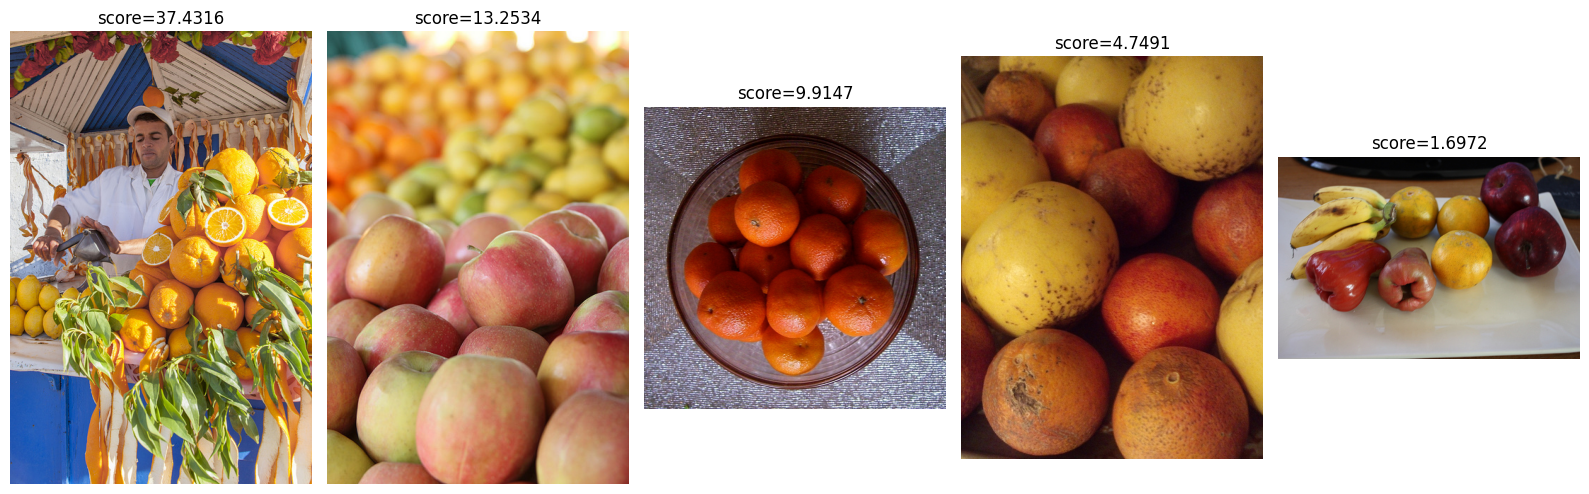

In [10]:
text_inputs = tokenizer([
    'Rank the numbers of oranges.',
] * len(image_array))

with torch.no_grad():
    output = model(
        image_array.to(device),
        text_inputs.to(device),
    )
prediction = output['adapter_logits'].cpu().numpy().ravel()

render_figures_with_order(
    image_list=[cv2.imread(image_path)[..., ::-1] for image_path in image_paths],
    values=prediction,
)

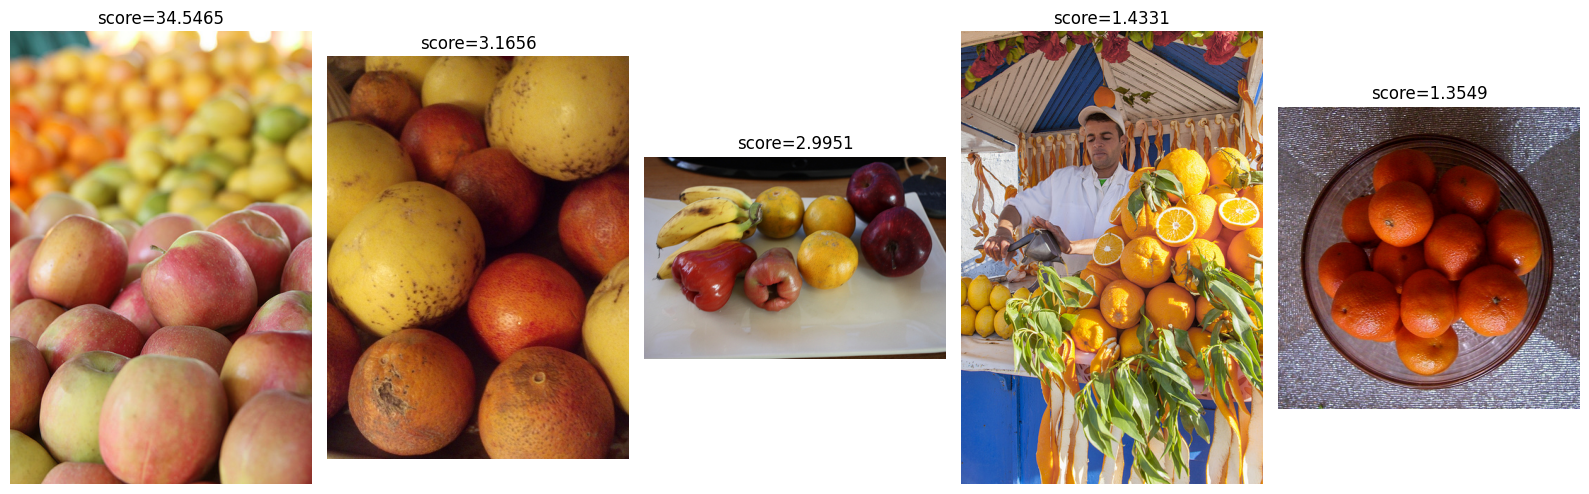

In [11]:
text_inputs = tokenizer([
    'Rank the numbers of apples.',
] * len(image_array))

with torch.no_grad():
    output = model(
        image_array.to(device),
        text_inputs.to(device),
    )
prediction = output['adapter_logits'].cpu().numpy().ravel()

render_figures_with_order(
    image_list=[cv2.imread(image_path)[..., ::-1] for image_path in image_paths],
    values=prediction,
)